## Cancer Survival Outcome Model
This dataset was taken from the METRABRIC database, which is a Canada-UK project  

Import Libraries 

In [4331]:
from __future__ import absolute_import,division,print_function, unicode_literals


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Importing Sklearn packages
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import normaltest, skew
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, accuracy_score, f1_score
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import classification_report, confusion_matrix
from scipy.special import boxcox, inv_boxcox

# Modeling libraries
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict,  KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from scipy.stats import zscore
from itertools import combinations
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans


from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf




Importing CSV file 

In [4332]:

dftrain = pd.read_csv('METABRIC_RNA_Mutation.csv')

dftrain.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [4333]:
dftrain.dtypes

patient_id                  int64
age_at_diagnosis          float64
type_of_breast_surgery     object
cancer_type                object
cancer_type_detailed       object
                           ...   
hras_mut                   object
prps2_mut                  object
smarcb1_mut                object
stmn2_mut                  object
siah1_mut                  object
Length: 693, dtype: object

In [4334]:
print(f"The shape of the train data set is: {dftrain.shape}")
dftrain.info()

The shape of the train data set is: (1904, 693)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 693 entries, patient_id to siah1_mut
dtypes: float64(498), int64(5), object(190)
memory usage: 10.1+ MB


In [4335]:
dftrain.drop('tumor_other_histologic_subtype', axis = 1)
dftrain.drop('cancer_type', axis = 1);

In [4336]:
#Finding missing data and the percentage of it in each column
total = dftrain.isnull().sum().sort_values(ascending = False)
percent = (dftrain.isnull().sum() / dftrain.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total_NaN', 'Percent_Nan'])
missing_data.head(20)

,Total_NaN,Percent_Nan
tumor_stage,501,0.263130
3-gene_classifier_subtype,204,0.107143
primary_tumor_laterality,106,0.055672
neoplasm_histologic_grade,72,0.037815
cellularity,54,0.028361
mutation_count,45,0.023634
er_status_measured_by_ihc,30,0.015756
type_of_breast_surgery,22,0.011555
tumor_size,20,0.010504
cancer_type_detailed,15,0.007878


The data missing is only on clinical values, and none of the genetic data is missing. To best represent and visualize the missing data, I will create a seperate clinical data dataframe. 

In [4337]:
dftrain.columns[:31] # tested values to find all columns representing the clinical values

Index(['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'cohort', 'er_status_measured_by_ihc',
       'er_status', 'neoplasm_histologic_grade',
       'her2_status_measured_by_snp6', 'her2_status',
       'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index', 'oncotree_code',
       'overall_survival_months', 'overall_survival', 'pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage', 'death_from_cancer'],
      dtype='object')

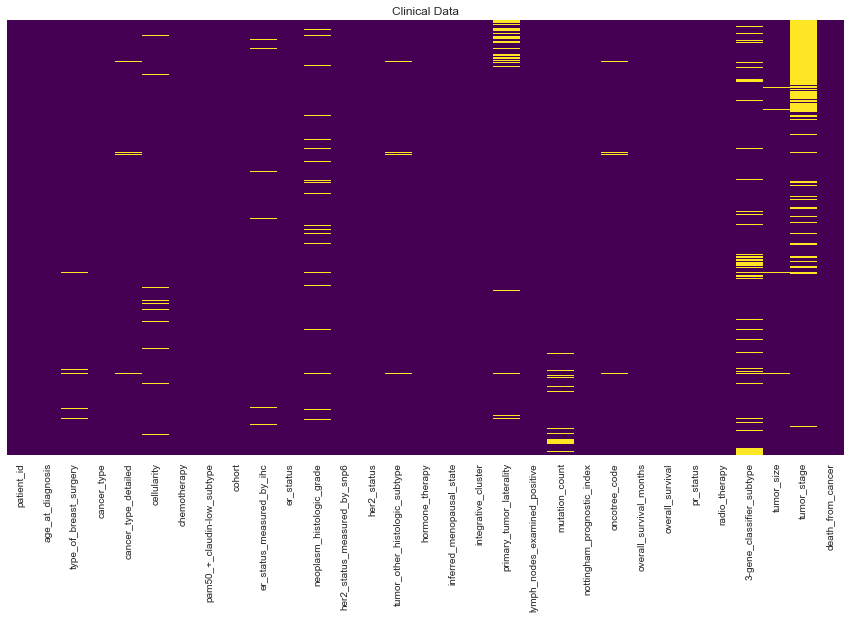

In [4338]:
non_clinical_data = dftrain.columns[31:] # All non clinical features
clinical_data = dftrain.drop(non_clinical_data, axis = 1) # dropping all clinical features
# Graphing the null values of the clinical features 
fig, ax = plt.subplots(figsize = (15,8))
sns.heatmap(clinical_data.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
ax.set_title('Clinical Data')
ax.invert_yaxis()
plt.show;

Text(0.5, 1.0, 'Correlations Among Features')

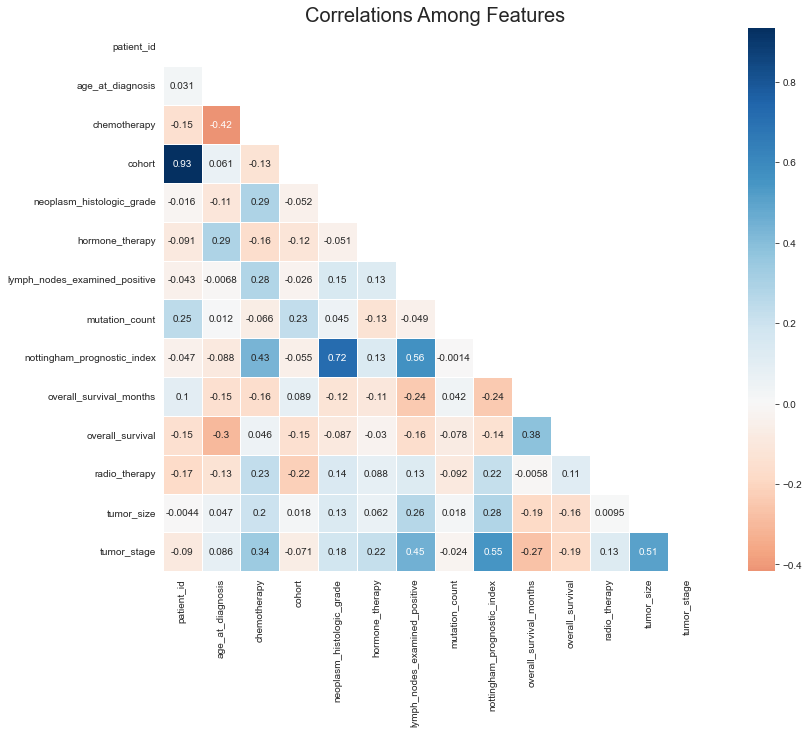

In [4339]:
corr  = clinical_data.corr()
mask = np.zeros_like(corr, dtype= bool)
mask[np.triu_indices_from(mask)] = True
sns.set_style('whitegrid')
plt.subplots(figsize = (15,10))
sns.heatmap(corr, annot = True, mask= mask, cmap = 'RdBu', linewidth = 0.9, linecolor  ='white', center = 0, square = True)
plt.title('Correlations Among Features', y = 1.00, fontsize = 20)

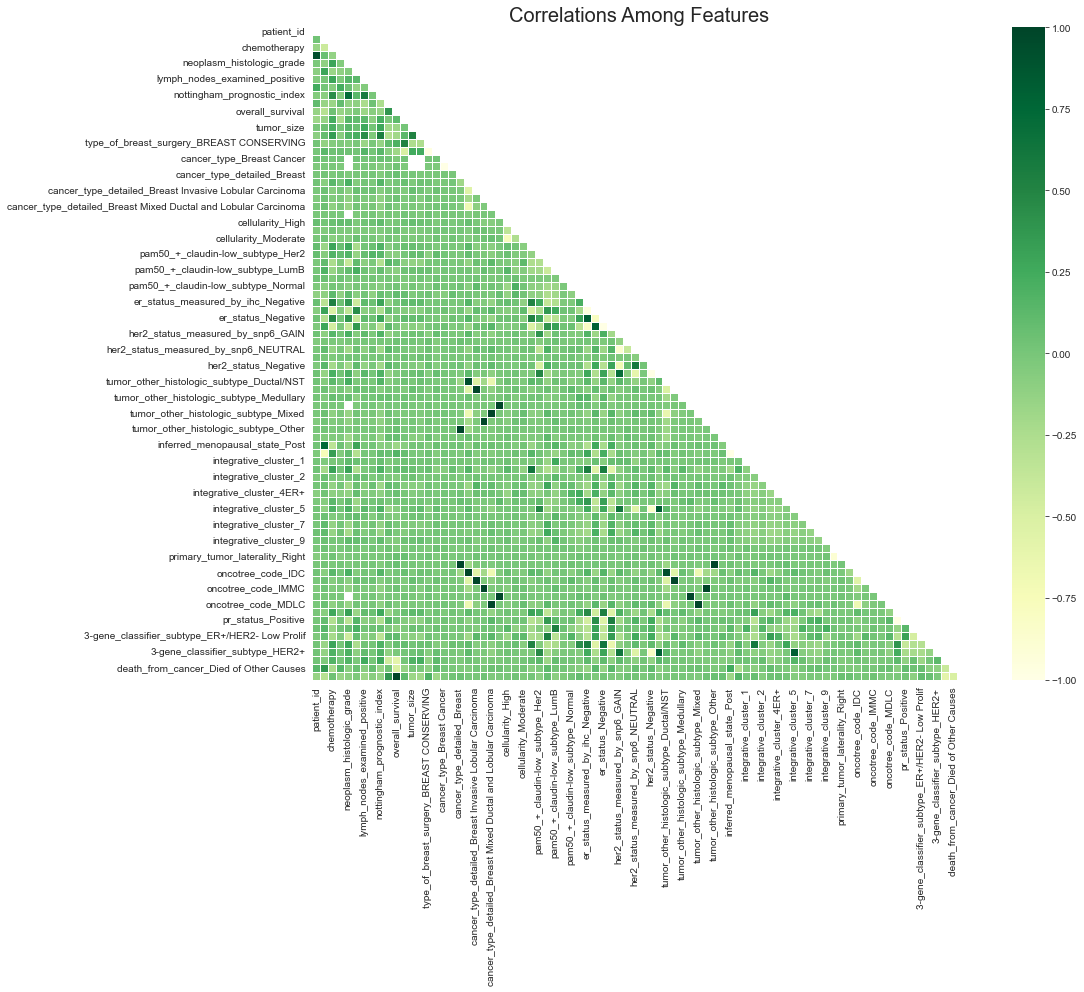

In [4340]:
sns.set_style('whitegrid')
categorical_vals = clinical_data.select_dtypes(include=['object']).columns.tolist()
clinical_df = pd.get_dummies(clinical_data, columns = categorical_vals)
mask = np.triu(np.ones_like(clinical_df.corr(), dtype = np.bool))
plt.subplots(figsize = (17,12))
sns.heatmap(clinical_df.corr(), annot = False, mask= mask, cmap = 'YlGn', linewidth = 0.9, linecolor  ='white', fmt = '.2g', center = 0, square = True)
plt.title('Correlations Among Features', y = 1.00, fontsize = 20)
plt.show();

There is correlation between different clinical values, but most of them are just showing how the same information is represented in different ways. For example, the figure shows that the oncotree code is actually just a way to represent the cancer type detailed, which is just helpful for me to have a better understanding of the data. 

In [4341]:
dftrain.drop('oncotree_code', axis =1) # direct correlation with cancer type feature

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,7295,43.10,BREAST CONSERVING,Breast Cancer,Breast Invasive Lobular Carcinoma,High,0,LumA,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1900,7296,42.88,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1901,7297,62.90,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1902,7298,61.16,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [4342]:
def cellularity(value):
    c = 0
    if value == 'High':
        c = 3
    elif value == 'Moderate':
        c = 2
    elif value == 'Low':
        c = 1
    return c


dftrain['cellularity_group'] = dftrain['cellularity'].map(cellularity)

In [4343]:
dftrain.neoplasm_histologic_grade.fillna("N", inplace = True)
# Comparing to nottingham index due to high correlation in values 
dftrain.groupby('neoplasm_histologic_grade', as_index=False)['nottingham_prognostic_index'].mean()


,neoplasm_histologic_grade,nottingham_prognostic_index
0,1.0,2.463097
1,2.0,3.610637
2,3.0,4.815522
3,N,1.897175


In [4344]:
# Function to get rid of the missing neoplasm grade values by using averages of available values
def neoplasm_grade(value):
    grade = 0
    if value < 3:
        grade = 1
    elif value >= 3 and value < 4.2:
        grade = 2
    else:
        grade = 3
    return grade

with_N = dftrain[dftrain.neoplasm_histologic_grade == 'N']
without_N = dftrain[dftrain.neoplasm_histologic_grade != 'N']

with_N['neoplasm_histologic_grade'] = with_N.nottingham_prognostic_index.apply(lambda x: neoplasm_grade(x))
all_data = pd.concat([with_N, without_N], axis = 0)
all_data.sort_values(by = 'patient_id', inplace=True)
dftrain = all_data

In [4345]:
#Finding missing data and the percentage of it in each column
total = dftrain.isnull().sum().sort_values(ascending = False)
percent = (dftrain.isnull().sum() / dftrain.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total_NaN', 'Percent_Nan'])
missing_data.head(15)

,Total_NaN,Percent_Nan
tumor_stage,501,0.263130
3-gene_classifier_subtype,204,0.107143
primary_tumor_laterality,106,0.055672
cellularity,54,0.028361
mutation_count,45,0.023634
er_status_measured_by_ihc,30,0.015756
type_of_breast_surgery,22,0.011555
tumor_size,20,0.010504
cancer_type_detailed,15,0.007878
tumor_other_histologic_subtype,15,0.007878


In [4346]:
clinical_data[clinical_data.death_from_cancer.isnull()]

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
1166,5130,58.61,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,Low,0,LumA,3.0,Positve,...,4.03,IDC,255.0,0,Positive,1,ER+/HER2- High Prolif,15.0,1.0,NaN


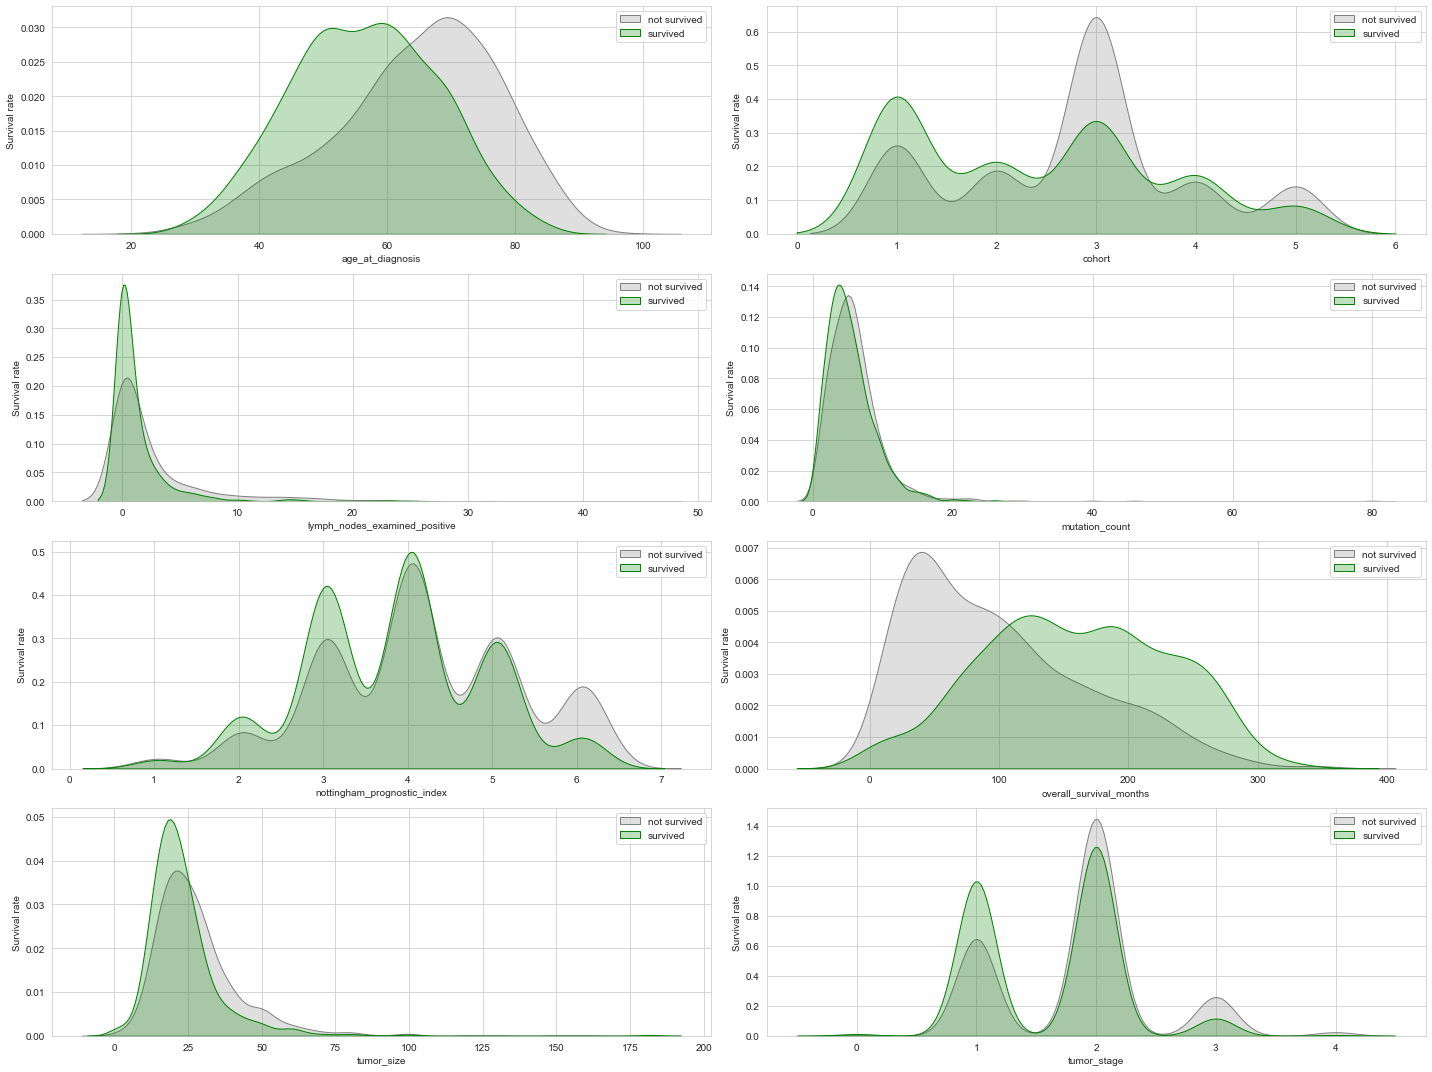

In [4347]:
# Graphing numerical values to their correlation to survival rate to get some initial understandings of correlation
numerical_values = ['age_at_diagnosis', 'cohort', 'lymph_nodes_examined_positive','mutation_count','nottingham_prognostic_index','overall_survival_months','tumor_size','tumor_stage']
a = 4 # num of rows
b = 2 # num of colums
c =1 # initializer value
fig, ax = plt.subplots(figsize = (20,15))
for i in numerical_values:
    plt.subplot(a,b,c)
    sns.kdeplot(dftrain.loc[(clinical_data['overall_survival'] == 0), i ] , color='gray',shade=True,label='not survived')
    sns.kdeplot(dftrain.loc[(clinical_data['overall_survival'] == 1), i] , color='g',shade=True, label='survived')
    plt.ylabel('Survival rate')
    plt.legend()
    c = c+1

plt.tight_layout()
plt.show()

# Initial Assumptions from clinical data
- Age of diagnosis > 70 results in lower survival rate
- Unsure of what the cohort mean but seem to correlate to lower survival in 3 and 5
- Lymph nodes positive over 5 are bad for survival
- Mutation count > ~5 bad for survival
- Nottingham index > 4 bad for survival
- Tumor size > 25 bad for survival
- Tumor stage >= 2 bad for survival

While the clinical data makes up a very small portion of the overall data available, it might start to give us a good insight into those who survive and don't and will help make easy indicators to train the model in the future. 

In [4348]:
clinical_data[clinical_data.death_from_cancer.isnull()]

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
1166,5130,58.61,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,Low,0,LumA,3.0,Positve,...,4.03,IDC,255.0,0,Positive,1,ER+/HER2- High Prolif,15.0,1.0,NaN


Based on trends in the data, I can only assume that this person did not die from cancer, as their data would usually correspond to a survival. Since they did die, we can assume it was non-cancer related.


In [4349]:
clinical_data.death_from_cancer.fillna('Died of Other Causes', inplace= True)

In [4350]:
clinical_data['mutation_count'] = clinical_data['mutation_count'].fillna(clinical_data['mutation_count'].mean())
clinical_data['tumor_size'] = clinical_data['tumor_size'].fillna(clinical_data['tumor_size'].mean())

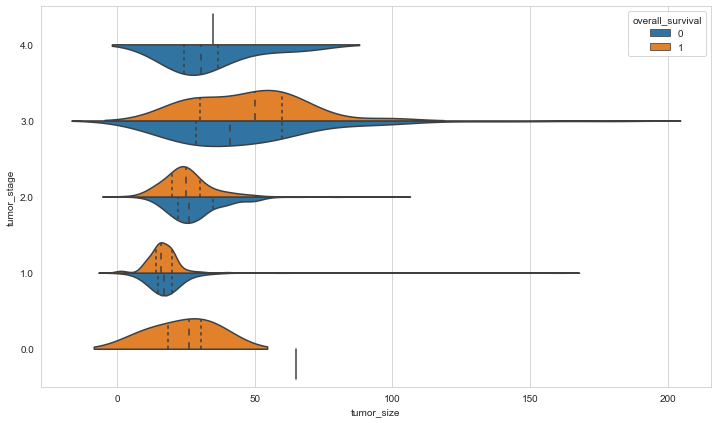

In [4351]:
fig, ax = plt.subplots(figsize = (12,7))
sns.violinplot(x = 'tumor_size', y= 'tumor_stage', hue = 'overall_survival', data = clinical_data, orient = 'h', split=True, inner= 'quart')
ax.invert_yaxis()

At tumor stage 3, there is the widest range of sizes associated. Generally as tumor state increases, tumor size also increases except for stage 4, where tumor size is smaller but survival rate is also extremely low. Interestingly, the average tumor size for stage 3 is larger for those that survived than those that didn't.

<AxesSubplot:xlabel='age_at_diagnosis', ylabel='overall_survival_months'>

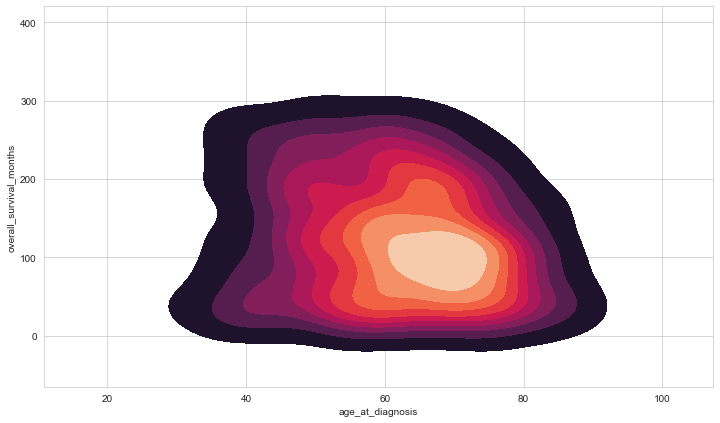

In [4352]:
fig, ax = plt.subplots(figsize = (12,7))

sns.kdeplot(x= 'age_at_diagnosis', y = 'overall_survival_months', data = clinical_data, cmap = 'rocket', fill = True)


As age increases, the overall survival months decreases, as people's immune systems are not as good at fighting back. 

<AxesSubplot:xlabel='mutation_count', ylabel='count'>

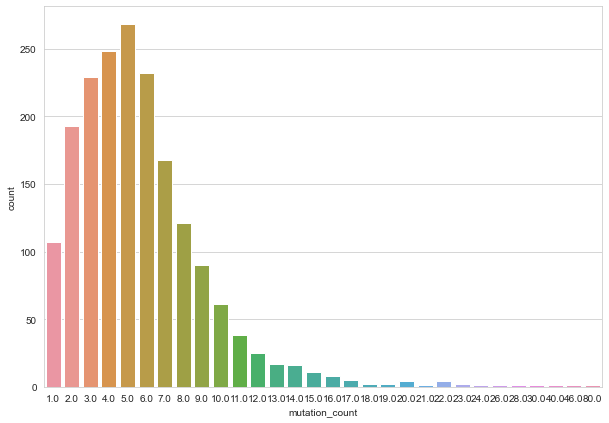

In [4353]:
plt.subplots(figsize = (10,7))
sns.countplot(x = 'mutation_count', data = dftrain)



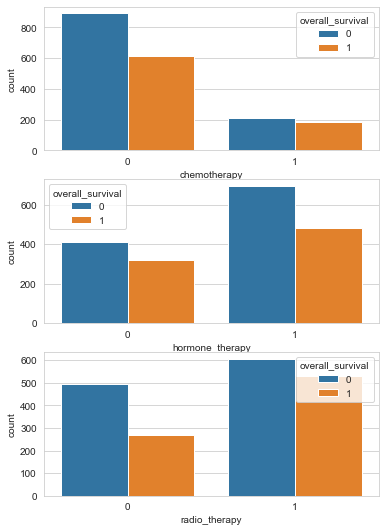

In [4354]:
therapies = ['chemotherapy','hormone_therapy', 'radio_therapy']
a = 3
b =1
c =1
fig, ax = plt.subplots(figsize = (6,9))
for i in therapies:
    plt.subplot(a,b,c)
    sns.countplot(x = i, hue = 'overall_survival', data = clinical_data)
    c = c+1

Hormone therapy has a relatively low rate of success, whereas radio and chemotherapy both have almost equal success to failure values. Radio therapy seems to be most successful since those that did not recieve the treatement had the highest rate of death. 

In [4355]:
corr_survival = clinical_df.corr()['overall_survival'].sort_values(ascending = False)
corr_dataframe = pd.DataFrame({"Correlation": corr_survival})
corr_dataframe.head(20)

,Correlation
death_from_cancer_Living,1.000000
overall_survival,1.000000
overall_survival_months,0.384467
type_of_breast_surgery_BREAST CONSERVING,0.187856
inferred_menopausal_state_Pre,0.170915
radio_therapy,0.112083
3-gene_classifier_subtype_ER+/HER2- Low Prolif,0.094463
pam50_+_claudin-low_subtype_claudin-low,0.091397
integrative_cluster_10,0.076256
pam50_+_claudin-low_subtype_LumA,0.065186


In [4356]:
corr_dataframe.tail(10)

,Correlation
patient_id,-0.148052
cohort,-0.149645
tumor_size,-0.164361
lymph_nodes_examined_positive,-0.164498
inferred_menopausal_state_Post,-0.170915
type_of_breast_surgery_MASTECTOMY,-0.184259
tumor_stage,-0.188790
age_at_diagnosis,-0.303666
death_from_cancer_Died of Other Causes,-0.494759
death_from_cancer_Died of Disease,-0.593581


# Correlations
Positive correlation between survival and survival months, breast conserving surgery, pre menopausal state, and radio therapy usage to name a few. On the other hand, there is a negative correlation between survival and age of diagnosis, tumor stage, mastectomy surgery and post menopausal state and positive lymph nodes. 

# Statistical Exploration


In [4357]:
numerical_values_clinical = ['age_at_diagnosis','lymph_nodes_examined_positive','mutation_count','overall_survival_months','tumor_size','nottingham_prognostic_index']
categorical_values_clinical = ['neoplasm_histologic_grade','tumor_stage','cohort','chemotherapy']
clinical_df[numerical_values_clinical].describe()

,age_at_diagnosis,lymph_nodes_examined_positive,mutation_count,overall_survival_months,tumor_size,nottingham_prognostic_index
count,1904.000000,1904.000000,1859.000000,1904.000000,1884.000000,1904.000000
mean,61.087054,2.002101,5.697687,125.121324,26.238726,4.033019
std,12.978711,4.079993,4.058778,76.334148,15.160976,1.144492
min,21.930000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,51.375000,0.000000,3.000000,60.825000,17.000000,3.046000
50%,61.770000,0.000000,5.000000,115.616667,23.000000,4.042000
75%,70.592500,2.000000,7.000000,184.716667,30.000000,5.040250
max,96.290000,45.000000,80.000000,355.200000,182.000000,6.360000


In [4358]:
clinical_data.astype("category").describe().T

,count,unique,top,freq
patient_id,1904,1904,0,1
age_at_diagnosis,1904.0,1572.0,49.61,5.0
type_of_breast_surgery,1882,2,MASTECTOMY,1127
cancer_type,1904,2,Breast Cancer,1903
cancer_type_detailed,1889,6,Breast Invasive Ductal Carcinoma,1500
cellularity,1850,3,High,939
chemotherapy,1904,2,0,1508
pam50_+_claudin-low_subtype,1904,7,LumA,679
cohort,1904.0,5.0,3.0,734.0
er_status_measured_by_ihc,1874,2,Positve,1445


This gives us an idea of the most frequent values of each of the clinical features, which may indicate which features are most important for the model building

In [4359]:
corr_survival = dftrain.corr()['overall_survival'].sort_values(ascending = False)
corr_dataframe = pd.DataFrame({"Correlation": corr_survival})
corr_dataframe

,Correlation
overall_survival,1.000000
overall_survival_months,0.384467
hsd17b11,0.216095
cdkn2c,0.197379
jak1,0.194412
...,...
map4,-0.165276
kmt2c,-0.171925
gsk3b,-0.186323
tumor_stage,-0.188790


This gives us our first exposure to the genetic data, which we have left alone until now because there is not much we can actually do without researching what each of the genes and mutations are. It is already clear that some genes contribute positively or negatively to the survival rate of the patient and will most likely be important for training our model. 

## Feature Engineering

In [4360]:
clinical_data.select_dtypes(include=[np.object])

,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,pam50_+_claudin-low_subtype,er_status_measured_by_ihc,er_status,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,oncotree_code,pr_status,3-gene_classifier_subtype,death_from_cancer
0,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,claudin-low,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Post,4ER+,Right,IDC,Negative,ER-/HER2-,Living
1,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumA,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Pre,4ER+,Right,IDC,Positive,ER+/HER2- High Prolif,Living
2,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumB,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Pre,3,Right,IDC,Positive,NaN,Died of Disease
3,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,LumB,Positve,Positive,NEUTRAL,Negative,Mixed,Pre,9,Right,MDLC,Positive,NaN,Living
4,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,LumB,Positve,Positive,NEUTRAL,Negative,Mixed,Post,9,Right,MDLC,Positive,ER+/HER2- High Prolif,Died of Disease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,BREAST CONSERVING,Breast Cancer,Breast Invasive Lobular Carcinoma,High,LumA,Positve,Positive,NEUTRAL,Negative,Lobular,Pre,3,Right,ILC,Positive,ER+/HER2- Low Prolif,Living
1900,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumB,Positve,Positive,GAIN,Positive,Ductal/NST,Pre,5,NaN,IDC,Negative,NaN,Died of Disease
1901,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumB,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Post,1,Left,IDC,Positive,NaN,Died of Disease
1902,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,LumB,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Post,1,NaN,IDC,Positive,ER+/HER2- High Prolif,Died of Other Causes


In [4361]:
dftrain['integrative_cluster'].unique()

array(['4ER+', '3', '9', '7', '4ER-', '5', '8', '10', '1', '2', '6'],
      dtype=object)

In [4362]:
def cluster_group(int):
    value = 0
    if int == '1':
        value = 1
    elif int == '2':
        value = 2
    elif int == '3':
        value = 3
    elif int == '4ER+' or '4ER-':
        value =4
    elif int == '5':
        value = 5
    elif int == '6':
        value = 6
    elif int == '7':
        value = 7
    elif int == '8':
        value = 8
    elif int == '9':
        value = 9
    elif int == '10':
        value = 10
    return value
dftrain['cluster_group'] = dftrain['integrative_cluster'].map(cluster_group)
dftrain.drop('integrative_cluster', axis =1, inplace= True)

In [4363]:
def cellularity_group(cell):
    value = 0 
    if cell == "High":
        value = 3
    elif cell == 'Moderate':
        value = 2
    elif cell == "Low":
        value = 1
    return value

dftrain['cellularity_group'] = dftrain['cellularity'].map(cellularity_group)
dftrain.drop('cellularity', axis=1, inplace = True)

In [4364]:
def er_group(stat):
    value = 0
    if stat == 'Positve' or 'Positive':
        value = 1
    elif stat == 'Negative':
        value = 0
    return value

dftrain['er_group_ilc'] = dftrain['er_status_measured_by_ihc'].map(er_group)
dftrain['er_group'] = dftrain['er_status'].map(er_group)
dftrain.drop('er_status_measured_by_ihc', axis=1, inplace=True)
dftrain.drop('er_status', axis =1, inplace=True)

In [4365]:
from cmath import nan


def her2_group(stat):
    value = 0
    if stat == 'NEUTRAL' or 'Negative':
        value = 0
    elif stat == "LOSS":
        value = -1
    elif stat == "GAIN" or 'Positive':
        value = 1
    else:
        value = nan
    return value
dftrain['her2_group_snp6'] = dftrain['her2_status_measured_by_snp6'].map(her2_group)
dftrain['her2_group'] = dftrain['her2_status'].map(her2_group)
dftrain['pr_group'] = dftrain['pr_status'].map(her2_group)
dftrain.drop('her2_status_measured_by_snp6', axis=1, inplace=True)
dftrain.drop('her2_status', axis=1, inplace=True)
dftrain.drop('pr_status',axis=1, inplace=True)

In [4366]:
dftrain = dftrain.replace('N',np.nan, regex = True)
dftrain.drop(['patient_id', 'cohort', 'death_from_cancer'], axis=1, inplace=True)

In [4367]:
dftrain = pd.get_dummies(dftrain, columns=["type_of_breast_surgery", 'cancer_type','cancer_type_detailed', 'pam50_+_claudin-low_subtype', 
 'tumor_other_histologic_subtype', 'inferred_menopausal_state','primary_tumor_laterality','oncotree_code','3-gene_classifier_subtype'], drop_first=True)

In [4368]:
dftrain.head()

,age_at_diagnosis,chemotherapy,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,...,inferred_menopausal_state_Pre,primary_tumor_laterality_Right,oncotree_code_IDC,oncotree_code_ILC,oncotree_code_IMMC,oncotree_code_MBC,oncotree_code_MDLC,3-gene_classifier_subtype_ER+/HER2- Low Prolif,3-gene_classifier_subtype_ER-/HER2-,3-gene_classifier_subtype_HER2+
0,75.65,0,3.0,1,10.0,NaN,6.044,140.500000,1,1,...,0,1,1,0,0,0,0,0,1,0
1,43.19,0,3.0,1,0.0,2.0,4.020,84.633333,1,1,...,1,1,1,0,0,0,0,0,0,0
2,48.87,1,2.0,1,1.0,2.0,4.030,163.700000,0,0,...,1,1,1,0,0,0,0,0,0,0
3,47.68,1,2.0,1,3.0,1.0,4.050,164.933333,1,1,...,1,1,0,0,0,0,1,0,0,0
4,76.97,1,3.0,1,8.0,2.0,6.080,41.366667,0,1,...,0,1,0,0,0,0,1,0,0,0


In [4369]:
dftrain = pd.get_dummies(dftrain, columns = dftrain.select_dtypes(include=['object']).columns, drop_first=True )

In [4370]:
dftrain.dropna(axis = 0, inplace=True)

In [4371]:
importances = dftrain.drop('overall_survival', axis = 1).apply(lambda x: x.corr(dftrain.overall_survival))
indices = np.argsort(importances)
print(importances[indices])

age_at_diagnosis          -0.305505
tumor_stage               -0.184713
gsk3b                     -0.181571
tumor_size                -0.178684
kmt2c                     -0.167553
                             ...   
hsd17b11                   0.210445
siah1_mut_T249A                 NaN
siah1_mut_T249A                 NaN
overall_survival_months    0.403978
siah1_mut_T249A                 NaN
Length: 7684, dtype: float64


In [4372]:
names = list(dftrain.columns)
new_feat = []
for i in range(0, len(indices)):
    if np.abs(importances[i])>0.18:
        new_feat.append(names[i])

In [4373]:
print(new_feat)

['age_at_diagnosis', 'overall_survival_months', 'tumor_size', 'src', 'gdf2', 'l1cam', 'cdk8', 'hsd17b10', 'sox9']


In [4374]:
X = dftrain.drop(['overall_survival'], axis =1)
y = dftrain['overall_survival']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y)

In [4375]:
from sklearn.preprocessing import StandardScaler
st_scale = StandardScaler()

X_train = st_scale.fit_transform(X_train) # use the standard scalar to set mean to 0 with variance 1 for X_train

X_test = st_scale.transform(X_test) # do the same for X_test

In [4376]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 120)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=120)

In [4377]:
model.score(X_test, y_test)

0.6544117647058824

In [4378]:
logreg = LogisticRegression(solver = 'liblinear', penalty = 'l1', random_state = 42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [4379]:
logreg.score(X_test, y_test)

0.75

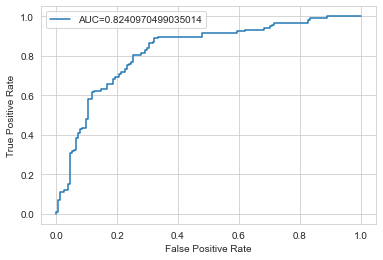

In [4380]:
from sklearn import metrics
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [4381]:
from random import random
from sklearn import tree
clf = tree.DecisionTreeClassifier(splitter = 'best', random_state = 42)
clf = clf.fit(X_train, y_train)

In [4382]:
clf.score(X_test, y_test)

0.6544117647058824

In [4383]:
from sklearn import svm 
support_model = svm.SVC(kernel='rbf')
support_model.fit(X_train,y_train)
support_model.score(X_test, y_test)

0.6985294117647058

In [4384]:
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
knn= GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1, cv=4)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.5294117647058824

In [4385]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
sel = SelectKBest(f_classif, k = 100)


new = sel.fit_transform(dftrain.drop(['overall_survival'], axis = 1), dftrain.overall_survival)

cols = sel.get_support(indices= True)
features_new_df = dftrain.iloc[:,cols]

In [4386]:
X_new = features_new_df
y_new = dftrain['overall_survival']
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.20, random_state = 42)

In [4387]:
from sklearn import svm 
support_model = svm.SVC()
support_model.fit(X_train_new,y_train_new)
support_model.score(X_test_new, y_test_new)

0.6838235294117647

In [4388]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(splitter = 'random', random_state = 42)
clf = clf.fit(X_train_new, y_train_new)
y_pred = clf.predict(X_test_new)
clf.score(X_test_new, y_test_new)

0.6433823529411765

In [4389]:
logreg = LogisticRegression(solver='liblinear', penalty = 'l1', random_state = 42)

logreg.fit(X_train_new, y_train_new)

y_pred = logreg.predict(X_test_new)

logreg.score(X_test_new, y_test_new)


0.7058823529411765